In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "../../data/bracelets_vs_necklaces/"
sz=224

In [4]:
os.listdir(PATH)

['tmp', 'train', 'models', 'valid']

In [5]:
files = os.listdir(f'{PATH}valid/bracelet')[:5]
files

['23. bellabracelet_1200x1200px_grande.jpg',
 '21. 3674208-rp-bm-bbl5-non.jpg',
 '24. cbd17pcrg_front.png',
 '25. 590702hv-1.jpg',
 '22. the_double_-_black_mens_black_leather_bracelet_grande.jpg']

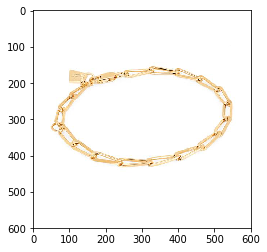

In [6]:
img = plt.imread(f'{PATH}valid/bracelet/{files[0]}')
plt.imshow(img);

In [7]:
img.shape

(600, 600, 3)

In [8]:
img[:4,:4]

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)

In [ ]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 5)

In [ ]:
print(data.val_y.shape)
display(data.classes)

In [ ]:
log_probs = learn.predict()
probs = np.exp(log_probs[:,1])
preds = np.argmax(log_probs,axis=1)
display(probs)
display(preds)

In [ ]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 2, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

data.val_ds    - validation dataset  in the form  of list of tuples [(d1,y1),(d2,y2)]
similar for data.trn_ds
data.val_ds.denorm  - function to reverse the normalization and applies on a batch of images

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [ ]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

#data.val_ds.fnames  -filenames of the validation dataset files

In [ ]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

In [ ]:
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [ ]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [ ]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

## Choosing a learning rate

In [17]:
arch=resnet34
#define batchsize bs here
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz),bs=2)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [18]:
lrf=learn.lr_find()

  0%|          | 0/20 [00:00<?, ?it/s, loss=4.95] 


In [19]:
print(lrf)

None


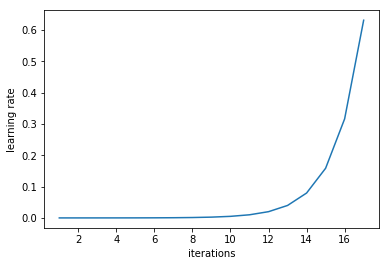

In [20]:
learn.sched.plot_lr()

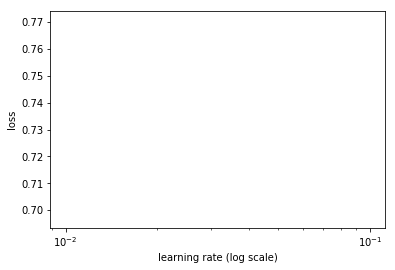

In [21]:
learn.sched.plot()

## Data augmentation

In [22]:
display(transforms_basic)
display(transforms_side_on)
display(transforms_top_down)

In [23]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

In [ ]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [ ]:
ims = np.stack([get_augs() for i in range(10)])
plots(ims, rows=2)

  0%|          | 0/20 [00:00<?, ?it/s, loss=51]   


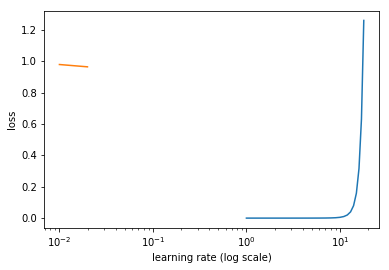

In [29]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms,bs=2)
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf = learn.lr_find()
learn.sched.plot_lr()
learn.sched.plot()
#learn.fit(1e-2, 3)

In [ ]:
learn.precompute=False
learn.fit(1e-2, 5, cycle_len=1)

In [ ]:
learn.sched.plot_lr()

### Fine-tuning and differential learning rate annealing

In [ ]:
learn.unfreeze()

In [ ]:
lr=np.array([1e-4,1e-3,1e-2])

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('224_all')

TTA predicts on actual validation images as well as augmented versions 
so log_preds has a shape of    augs,n_valid_images,classes

In [ ]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

In [ ]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

In [ ]:
plot_confusion_matrix(cm, data.classes)

1. Enable data augmentation, and precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting